# Checking every step of preprocessing

In [79]:
import os
import numpy as np
import tensorflow
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as ss
from scipy.stats import kurtosis, zscore
from sklearn import preprocessing
import keras
import PyQt5
from sklearn.model_selection import train_test_split
import pandas as pd
# %matplotlib notebook
mne.set_log_level(verbose='CRITICAL')

### Manualy chosen bad channels for each participant

Excluding bad participants also.

In [90]:
male_participants = ['m'+str(i) for i in range(1,19)]
female_participants = ['k'+str(i) for i in range(1,19)]
all_participants = set(male_participants + female_participants) - {'k7','k8','k10','k11','k12','k13','m14','m16'}
good_participants = sorted(list(all_participants))
bad_channels = [['T3','T4','T6'],[],['Fp1','Fp2','Fz'],
                ['P3','O2'],['O1','O2'],['F3','Fz','F4','F8','Fp1','Fp2'],[],[],[],[],[],[],
                ['O1','O2'],[],['O1','O2','Fz','F4','Fp1','Fp2'],['F3','Fz','F4','Fp1','Fp2'],['F3'],
                ['T4','Fz','Fp1','Fp2'],['O1','O2','T6','F4','Fp2'],[],[],['Pz'],['F3','Fz','F4','Fp1','Fp2'],
                ['F3','Fz','F4','Fp1','Fp2'],[],['O1','O2'],['T4','O1','T3'],['F3','Fz','F4','Fp1','Fp2']]
channels_dict = {}
for i in range(len(good_participants)):
    channels_dict[good_participants[i]] = bad_channels[i]


In [91]:
# mne.set_log_level(verbose='CRITICAL')
# for part in set(male_participants + female_participants):
#     print(part)
#     file = mne.io.read_raw_eeglab('./data2/'+part+'.set',preload=True)
#     file.set_eeg_reference(ref_channels=['A1','A2']) 
#     file.drop_channels(['EOG','dioda','TSS','A1','A2'])
#     file.filter(0.5,49,method='iir')
#     file.plot()

# Functions for preprocessing

In [92]:
def get_bad_epochs(signal,percentiles = [25,75]): #shape = ( epochs, channels, samples)
    channels = signal.shape[1]
    Qstd = np.std(signal,axis = -1)
    Qkurt = kurtosis(signal,axis = -1)
    bads = np.empty(0)
    for i in range(channels):
        Q1,Q3 = np.percentile(Qstd[:,i],percentiles)
        IQR = Q3-Q1
        range_std = (Q1-1.5*IQR,Q3+1.5*IQR)
        Q1,Q3 = np.percentile(Qkurt[:,i],percentiles)
        IQR = Q3-Q1
        range_kurt = (Q1-1.5*IQR,Q3+1.5*IQR)
        right_std = np.where(Qstd[:,i] > range_std[1])[0]
        left_std = np.where(Qstd[:,i] < range_std[0])[0]
        right_kurt = np.where(Qkurt[:,i] > range_kurt[1])[0]
        left_kurt = np.where(Qkurt[:,i] < range_kurt[0])[0]
        bads = np.unique(np.concatenate((bads,left_kurt,right_kurt,left_std,right_std)))
    return bads

def RMS(signal, window_size):
    signal2 = signal**2
    window = np.ones(window_size)/window_size
    return np.sqrt(np.convolve(signal2, window, 'same'))

### First step: reading data (using mne)

In [93]:
participant = 'k1'
file = mne.io.read_raw_eeglab('./data2/'+participant+'.set',preload=True)
before_ref = file.get_data() #extracting data before setting refrence channels to see any changes

'''Setting refrence channels (ears)'''
file.set_eeg_reference(ref_channels=['A1','A2']) 
after_ref = file.get_data() #extracting data after setting refrence (checking changes)

'''Dropping (removing) redundant channels'''
file.drop_channels(['EOG','dioda','TSS','A1','A2'])

Reading ./data2/k1.fdt
Reading 0 ... 4466687  =      0.000 ...  4361.999 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawEEGLAB | k1.fdt, 19 x 4466688 (4362.0 s), ~647.5 MB, data loaded>

Plotting changes for refrence channels

https://mne.tools/dev/generated/mne.set_eeg_reference.html

It uses average in default

<IPython.core.display.Javascript object>


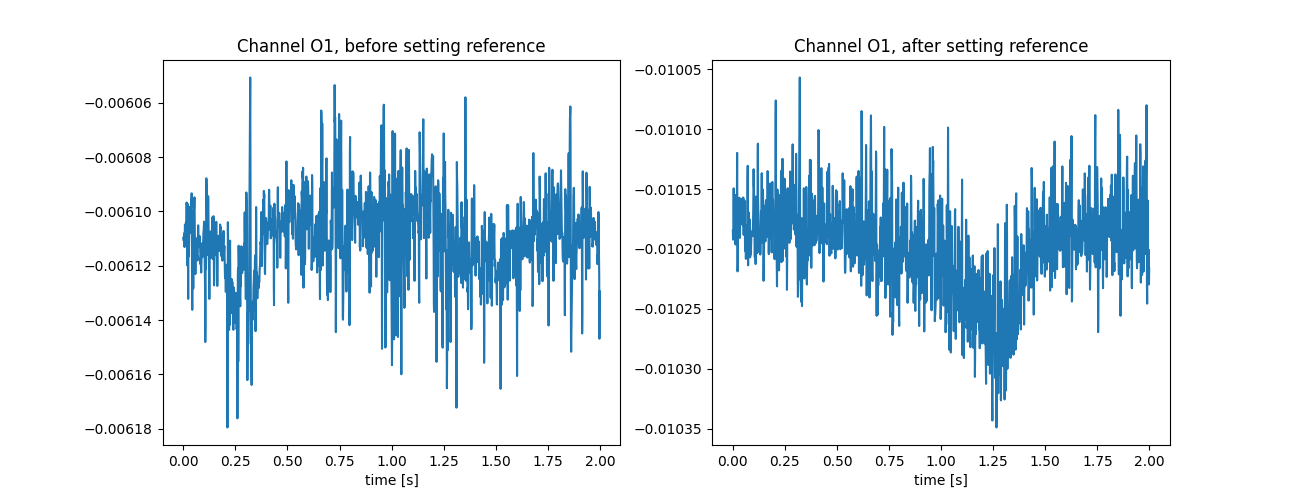

In [94]:
Fs = int(file.info['sfreq'])
channels = file.info['ch_names']

ch = 0
time = np.arange(0,2,1/Fs)

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.plot(time,before_ref[ch,100*Fs:102*Fs])
plt.title(f'Channel {channels[ch]}, before setting reference')
plt.xlabel('time [s]')

plt.subplot(1,2,2)
plt.plot(time,after_ref[ch,100*Fs:102*Fs])
plt.title(f'Channel {channels[ch]}, after setting reference')
plt.xlabel('time [s]')
plt.show()

### Second step: Filtering

#### Checking impulse response

Setting up band-pass filter from 0.5 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 6759 samples (6.601 sec)



<IPython.core.display.Javascript object>


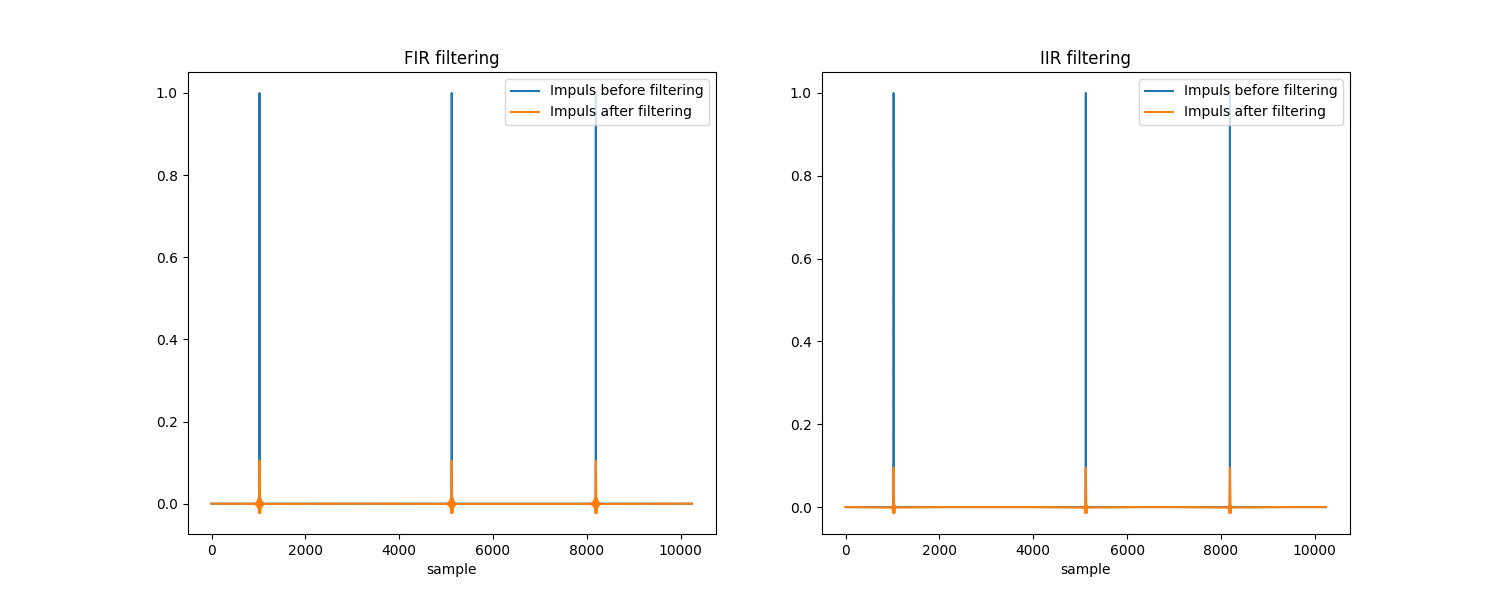

Setting up band-pass filter from 0.5 - 48 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 48.00 Hz: -6.02, -6.02 dB



In [95]:
'''FIR method'''
impulse = np.zeros(10*Fs)
impulse[1*Fs] = 1
impulse[5*Fs] = 1
impulse[8*Fs] = 1
filt_imp = mne.filter.filter_data(impulse,Fs,0.5,48) #default is fir method

plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
plt.plot(impulse, label = 'Impuls before filtering')
plt.plot(filt_imp, label = 'Impuls after filtering')
plt.xlabel('sample')
plt.title('FIR filtering')
plt.legend(loc = 'upper right')

'''IIR method'''
impulse = np.zeros(10*Fs)
impulse[1*Fs] = 1
impulse[5*Fs] = 1
impulse[8*Fs] = 1
filt_imp = mne.filter.filter_data(impulse,Fs,0.5,48,method='iir')

plt.subplot(1,2,2)
plt.plot(impulse, label = 'Impuls before filtering')
plt.plot(filt_imp, label = 'Impuls after filtering')
plt.title('IIR filtering')
plt.xlabel('sample')
plt.legend(loc = 'upper right')
plt.show()

### Maybe IIR mehod will be better because of smaller "beads" around impulse?

## Filtering data

In [96]:
mne.set_log_level(verbose=None) #for mne to tell us specification of filters

before_filtering = after_ref

file.filter(0.5,49,method='iir')

after_filtering = file.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 49 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 49.00 Hz: -6.02, -6.02 dB



<IPython.core.display.Javascript object>


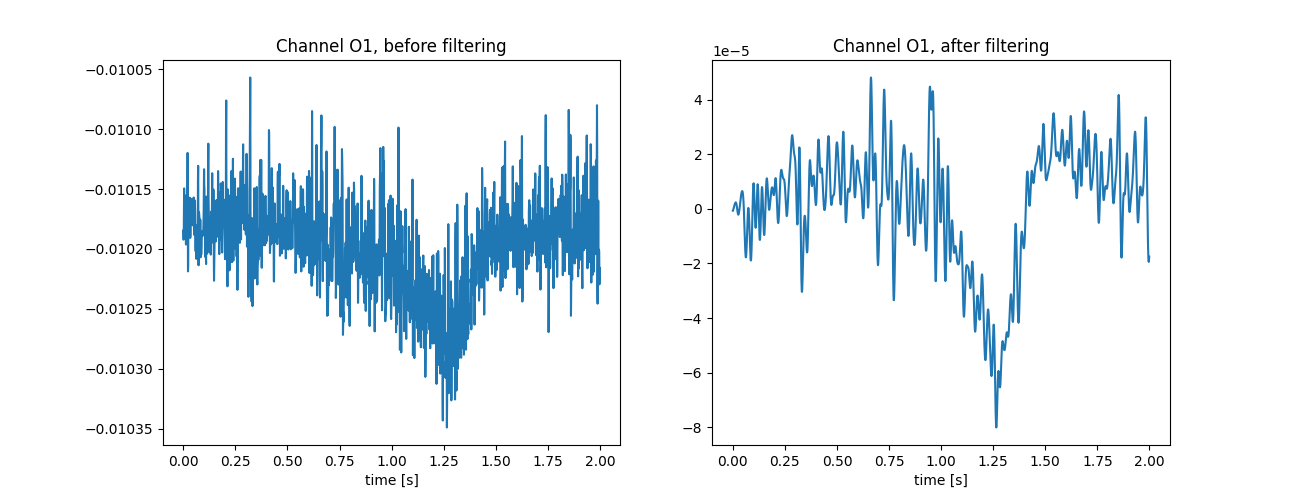

In [97]:
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.plot(time,before_filtering[ch,100*Fs:102*Fs])
plt.title(f'Channel {channels[ch]}, before filtering')
plt.xlabel('time [s]')

plt.subplot(1,2,2)
plt.plot(time,after_filtering[ch,100*Fs:102*Fs])
plt.title(f'Channel {channels[ch]}, after filtering')
plt.xlabel('time [s]')
plt.show()

In [98]:
ch_ind = channels.index(channels_dict[participant][1])
ch_before_interp = after_filtering[ch_ind,:]

file.info['bads'] = channels_dict[participant]
file.interpolate_bads(reset_bads=False, mode='accurate', origin=[0,0,0])
ch_after_interp = file.get_data()[ch_ind,:]


Computing interpolation matrix from 16 sensor positions
Interpolating 3 sensors


<IPython.core.display.Javascript object>


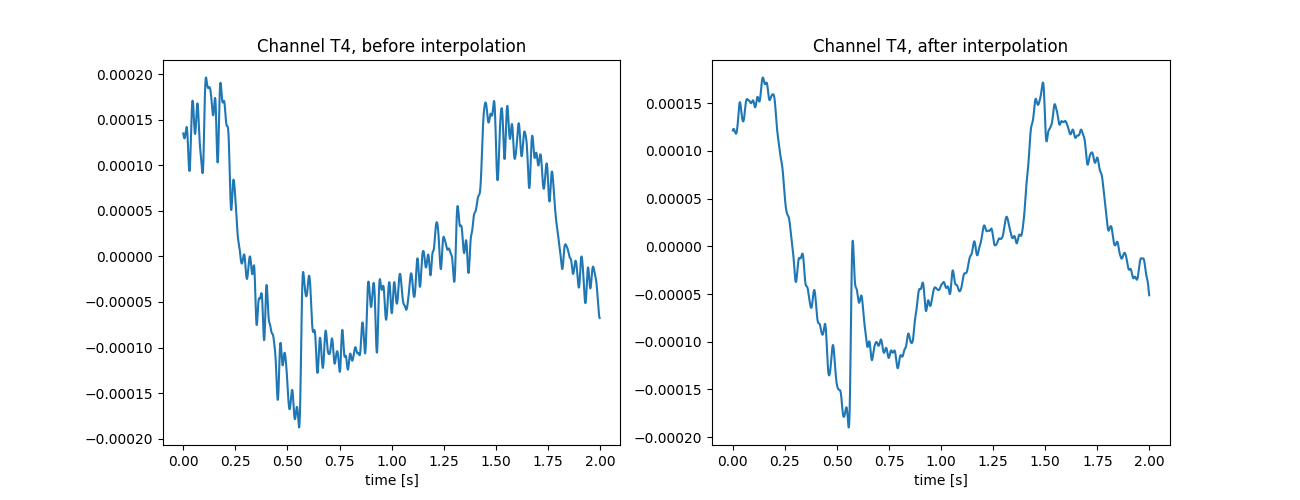

In [100]:
ch_ind = channels.index(channels_dict[participant][1])

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.plot(time,ch_before_interp[200*Fs:202*Fs])
plt.title(f'Channel {channels[ch_ind]}, before interpolation')
plt.xlabel('time [s]')

plt.subplot(1,2,2)
plt.plot(time,ch_after_interp[200*Fs:202*Fs])
plt.title(f'Channel {channels[ch_ind]}, after interpolation')
plt.xlabel('time [s]')
plt.show()